# Hyperparameter optimization and model finalization

This notebook trains and optimizes the RF and XGBoost model for our dataset.

In [1]:
import os
import pickle
import json
import optuna
import pandas as pd
from tqdm import tqdm
import logging
import torch

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from treeinterpreter import treeinterpreter as ti
from hpo_trainer import objective_rf, report, SEED, finalize_model, objective_xgboost

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings

warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)  # Disabling trial info messages

In [3]:
logger = logging.getLogger(__name__)

# Hyperparameter Optimization (HPO)

### Random Forest

In [4]:
for fingerprint_name in ["ecfp4", "rdkit", "maccs", "erg", "chemphys", "mhfp6"]:
    if os.path.exists(f"../models/{fingerprint_name}_rf.pkl"):
        continue

    train_data = pd.read_csv(f"../data/splits/{fingerprint_name}_smote_train.csv")

    X_train, y_train = train_data.drop("label", axis=1), train_data["label"]

    # Start HPO process
    logger.warning(f"Starting HPO for {fingerprint_name}...")
    study = optuna.create_study(
        direction="maximize", study_name=f"{fingerprint_name}_rf"
    )
    study.optimize(
        lambda trial: objective_rf(
            trial, study_name=study.study_name, X_train=X_train, y_train=y_train
        ),
        n_trials=15,
        show_progress_bar=True,
    )

    logger.warning("All trials saved in experiments folder.")

    # Train a new model using the best parameters
    best_model = RandomForestClassifier(random_state=SEED, **study.best_params)
    best_model.fit(X_train, y_train)

    # Save the best model
    finalize_model(
        model=best_model, params=study.best_params, exp_name=study.study_name
    )

### XGBoost

In [5]:
for fingerprint_name in ["ecfp4", "rdkit", "maccs", "erg", "chemphys", "mhfp6"]:
    if os.path.exists(f"../models/{fingerprint_name}_xgboost.pickle.dat"):
        continue

    train_data = pd.read_csv(f"../data/splits/{fingerprint_name}_smote_train.csv")

    X_train, y_train = train_data.drop("label", axis=1), train_data["label"]

    # Start HPO process
    logger.warning(f"Starting HPO for {fingerprint_name}...")
    study = optuna.create_study(
        direction="maximize", study_name=f"{fingerprint_name}_xgboost"
    )
    study.optimize(
        lambda trial: objective_xgboost(
            trial, study_name=study.study_name, X_train=X_train, y_train=y_train
        ),
        n_trials=15,
        show_progress_bar=True,
    )

    logger.warning("All trials saved in experiments folder.")

    # Train a new model using the best parameters
    label_to_idx = {
        "gram-negative": 0,
        "gram-positive": 1,
        "acid-fast": 2,
        "unselective": 3,
    }

    # Training data
    y_train = y_train.map(label_to_idx)

    # Save the best model
    best_model = xgb.XGBClassifier(**study.best_params, seed=SEED)
    best_model.fit(X_train, y_train)

    model_path = f"../models"

    os.makedirs(model_path, exist_ok=True)
    pickle.dump(best_model, open(f"{model_path}/{study.study_name}.pickle.dat", "wb"))

    # Save params
    with open(f"{model_path}/{study.study_name}_params.json", "w") as f:
        json.dump(study.best_params, f, indent=4, sort_keys=True, ensure_ascii=False)

# Model evaluation on test data

In [6]:
final_result_list = []
fpr_list = []
tpr_list = []
labels = []

for fingerprint_name in tqdm(["ecfp4", "rdkit", "maccs", "mhfp6", "erg", "chemphys"]):
    # Random Forest
    study_name = f"{fingerprint_name}_rf"
    rf_model = torch.load(f"../models/{study_name}.pkl")

    test_data = pd.read_csv(f"../data/splits/{fingerprint_name}_test.csv")
    X_test, y_test = test_data.drop("label", axis=1), test_data["label"]

    y_pred = rf_model.predict(X_test)

    report_df, fpr, tpr = report(
        y_test=y_test,
        y_pred=y_pred,
        model=rf_model,
        exp_name=study_name,
    )

    final_result_list.append(report_df)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    if fingerprint_name == "chemphys":
        labels.append("ChemPhys_RF")
    elif fingerprint_name == "mhfp6":
        labels.append("MHFP6_RF")
    elif fingerprint_name == "ecfp4":
        labels.append("ECFP4_RF")
    elif fingerprint_name == "rdkit":
        labels.append("RDKit_RF")
    elif fingerprint_name == "maccs":
        labels.append("MACCS_RF")
    elif fingerprint_name == "erg":
        labels.append("ErG_RF")

    # Confusion Matrix
    label_classes = rf_model.classes_.tolist()

    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=label_classes)
    plt.figure(figsize=(8, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        yticklabels=[i.capitalize() for i in label_classes],
        xticklabels=[i.capitalize() for i in label_classes],
    )
    plt.xlabel("Predicted label", fontsize=14, fontweight="bold")
    plt.ylabel("True label", fontsize=14, fontweight="bold")
    plt.title(f"{fingerprint_name.upper()} Confusion Matrix", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    os.makedirs("../reports", exist_ok=True)
    plt.tight_layout()

    plt.savefig(f"../reports/{study_name}_confusion_matrix.png", dpi=400)
    plt.close()

    # XGBoost
    study_name = f"{fingerprint_name}_xgboost"
    xgboost_model = pickle.load(open(f"../models/{study_name}.pickle.dat", "rb"))

    # Train a new model using the best parameters
    label_to_idx = {
        "gram-negative": 0,
        "gram-positive": 1,
        "acid-fast": 2,
        "unselective": 3,
    }

    # Label mapping to integers
    y_test = y_test.map(label_to_idx)

    # Testing data
    y_pred = xgboost_model.predict(X_test)
    report_df, fpr, tpr = report(
        y_test=y_test,
        y_pred=y_pred,
        model=xgboost_model,
        exp_name=study_name,
    )

    final_result_list.append(report_df)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    if fingerprint_name == "chemphys":
        labels.append("ChemPhys_XGBoost")
    elif fingerprint_name == "mhfp6":
        labels.append("MHFP6_XGBoost")
    elif fingerprint_name == "ecfp4":
        labels.append("ECFP4_XGBoost")
    elif fingerprint_name == "rdkit":
        labels.append("RDKit_XGBoost")
    elif fingerprint_name == "maccs":
        labels.append("MACCS_XGBoost")
    elif fingerprint_name == "erg":
        labels.append("ErG_XGBoost")

    # Confusion matrix
    label_classes = xgboost_model.classes_.tolist()

    idx_to_label = {idx: label for label, idx in label_to_idx.items()}

    cm = confusion_matrix(y_test, y_pred, labels=label_classes)
    plt.figure(figsize=(8, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        yticklabels=[idx_to_label[i].capitalize() for i in label_classes],
        xticklabels=[idx_to_label[i].capitalize() for i in label_classes],
    )
    plt.xlabel("Predicted label", fontsize=14, fontweight="bold")
    plt.ylabel("True label", fontsize=14, fontweight="bold")
    plt.title(f"{fingerprint_name.upper()} Confusion Matrix", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.savefig(f"../reports/{study_name}_confusion_matrix.png", dpi=400)
    plt.close()

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:19<00:00,  3.32s/it]


# AUC-ROC Comparison across fingerprints

In [7]:
metric_df = pd.concat(final_result_list)
metric_df.sort_values(
    by=["cohen_kappa", "roc_auc"], ascending=[False, False], inplace=True
)
metric_df

,accuracy,cohen_kappa,macro_precision,macro_recall,macro_f1,roc_auc
chemphys_rf,0.946192,0.915930,0.932035,0.932374,0.932200,0.955834
mhfp6_rf,0.838936,0.740834,0.824925,0.763902,0.790146,0.847955
rdkit_rf,0.827115,0.722535,0.796444,0.746425,0.768302,0.837324
maccs_rf,0.821574,0.720507,0.764254,0.767258,0.765639,0.849418
mhfp6_xgboost,0.824529,0.719904,0.789685,0.756901,0.771947,0.842479
ecfp4_rf,0.816679,0.701525,0.801264,0.727736,0.758321,0.823844
rdkit_xgboost,0.809752,0.700398,0.755086,0.748399,0.751372,0.836967
erg_rf,0.787991,0.664912,0.732072,0.707463,0.718773,0.811593
ecfp4_xgboost,0.772442,0.643040,0.713763,0.715959,0.714613,0.813775
maccs_xgboost,0.750924,0.624273,0.675539,0.734659,0.696717,0.823424


In [8]:
# Plot ROC curves for RF and XGBoost separately only
rf_idx = [i for i, label in enumerate(labels) if "RF" in label]
fpr_list_rf = [fpr_list[i] for i in rf_idx]
tpr_list_rf = [tpr_list[i] for i in rf_idx]
labels_rf = [labels[i] for i in rf_idx]

xgboost_idx = [i for i, label in enumerate(labels) if "XGBoost" in label]
fpr_list_xgboost = [fpr_list[i] for i in xgboost_idx]
tpr_list_xgboost = [tpr_list[i] for i in xgboost_idx]
labels_xgboost = [labels[i] for i in xgboost_idx]

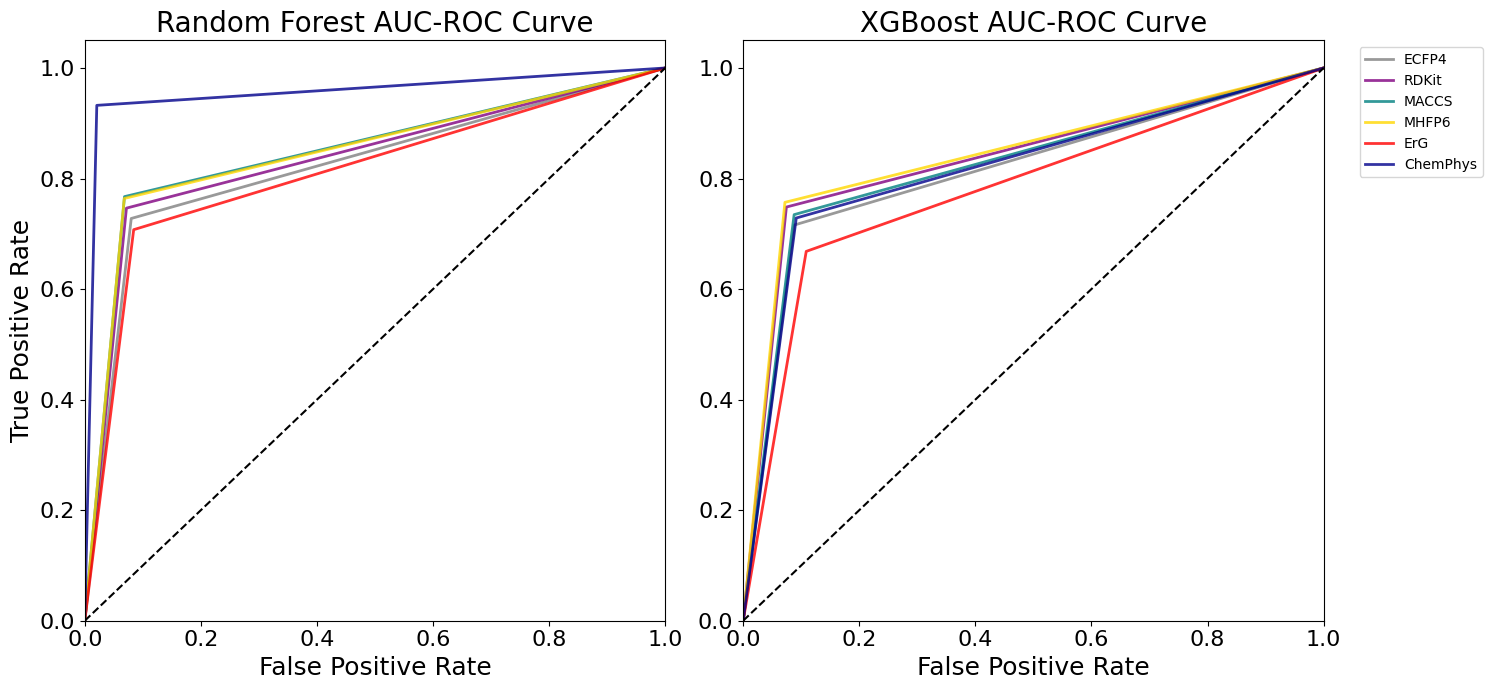

In [9]:
plt.figure(figsize=(15, 7))

colors = ["gray", "purple", "teal", "gold", "red", "darkblue"]

plt.subplot(1, 2, 1)
for i in range(len(fpr_list_rf)):
    sns.lineplot(
        x=fpr_list_rf[i],
        y=tpr_list_rf[i],
        markers=True,
        markersize=10,
        dashes=True,
        linewidth=2,
        alpha=0.8,
        label=labels_rf[i],
        color=colors[i],
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.title("Random Forest AUC-ROC Curve", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend().remove()

plt.subplot(1, 2, 2)
for i in range(len(fpr_list_xgboost)):
    sns.lineplot(
        x=fpr_list_xgboost[i],
        y=tpr_list_xgboost[i],
        markers=True,
        markersize=10,
        dashes=True,
        linewidth=2,
        alpha=0.8,
        label=labels_xgboost[i].replace("_XGBoost", ""),
        color=colors[i],
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("")
plt.title("XGBoost AUC-ROC Curve", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.savefig("../reports/auc_roc_curve.png", dpi=400)
plt.show()

# Feature importance

### Features most prominently used for tree splits

In [10]:
for fingerprint_name in ["ecfp4", "rdkit", "maccs", "mhfp6", "erg", "chemphys"]:
    study_name = f"{fingerprint_name}_rf"
    best_model = torch.load(f"../models/{study_name}.pkl")

    train_data = pd.read_csv(f"../data/splits/{fingerprint_name}_smote_train.csv")
    test_data = pd.read_csv(f"../data/splits/{fingerprint_name}_test.csv")

    X_train, y_train = train_data.drop("label", axis=1), train_data["label"]
    X_test, y_test = test_data.drop("label", axis=1), test_data["label"]

    global_importances = pd.Series(
        best_model.feature_importances_, index=X_train.columns
    )
    global_importances.sort_values(ascending=False, inplace=True)
    global_importances = global_importances[:10]  # top 10 features

    plt.figure(figsize=(10, 8))
    sns.barplot(
        x=global_importances.values,
        y=global_importances.index,
        color="#20b2aa",
        orient="h",
    )
    plt.xlabel("Importance", fontsize=18)
    plt.ylabel("Features", fontsize=18)
    plt.title(f"Global Feature Importance {fingerprint_name.upper()}", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()

    plt.savefig(f"../reports/{study_name}_global_feature_importance.png", dpi=400)
    plt.close()

# Directionality of feature

In [11]:
chemphys_model = torch.load(f"../models/chemphys_rf.pkl")

test_data = pd.read_csv(f"../data/splits/chemphys_test.csv")
X_test, y_test = test_data.drop("label", axis=1), test_data["label"]

In [12]:
# time consuming step
prediction, bias, contributions = ti.predict(chemphys_model, X_test)

In [13]:
feature_contributions = []

for i, prop_name in zip(contributions[0], X_test.columns):
    for j, feature in zip(i, chemphys_model.classes_.tolist()):
        feature_contributions.append(
            {"prop_name": prop_name, "contribution": j, "class": feature}
        )

len(feature_contributions)

128

In [14]:
contribution_df = pd.DataFrame(feature_contributions)
feature_importance_df = (
    contribution_df.groupby("prop_name")["contribution"].median().reset_index()
)
feature_importance_df.sort_values(by="contribution", ascending=False, inplace=True)
feature_importance_df.head(2)

,prop_name,contribution
11,NumAromaticHeterocycles,0.009449
5,Largest Pi Chain,0.004552


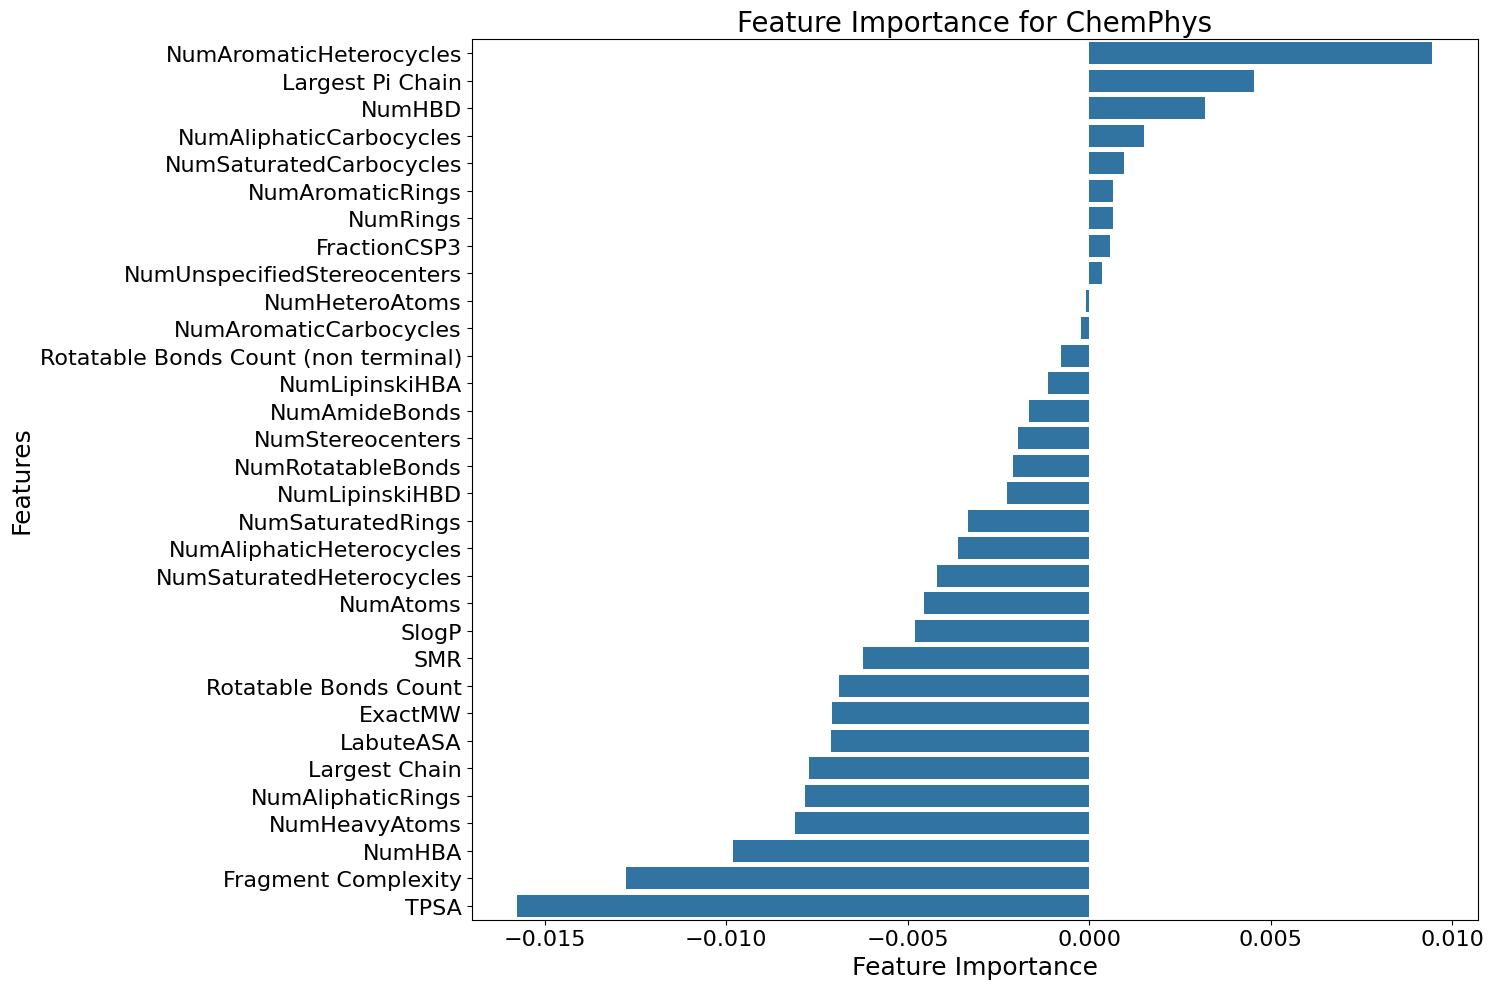

In [15]:
plt.figure(figsize=(15, 10))
sns.barplot(
    data=feature_importance_df,
    y="prop_name",
    x="contribution",
)
plt.xlabel("Feature Importance", fontsize=18)
plt.ylabel("Features", fontsize=18)
plt.title("Feature Importance for ChemPhys", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig("../reports/chemphys_rf_feature_importance_directional.png", dpi=400)
plt.show()